# Recreate Figure 2I

In [1]:
import os,sys
import datetime

In [2]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.2 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1
Memory usage: current 0.18 GB, difference +0.18 GB


In [3]:
"""# This cell is run once to download my custom functions and import statements from github

!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
    
# github doesn't seem to have an option to download a specific version of the repo from the history.
# So I download my utility functions and save the download time by appending it to the directory name.
# These utility functions to be shared together with the notebook.

toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
newname = "utility_functions_%s"%toappend
print(newname)


# rename the py file with utility functions
os.rename("utility_functions",newname)"""

'# This cell is run once to download my custom functions and import statements from github\n\n!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions\n    \n# github doesn\'t seem to have an option to download a specific version of the repo from the history.\n# So I download my utility functions and save the download time by appending it to the directory name.\n# These utility functions to be shared together with the notebook.\n\ntoappend = datetime.datetime.now().strftime(\'%y%m%d_%Hh%M\')\nnewname = "utility_functions_%s"%toappend\nprint(newname)\n\n\n# rename the py file with utility functions\nos.rename("utility_functions",newname)'

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_200517_09h14/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.7.4


# Load data

In [1]:
adata = sc.read_h5ad('data/mito_total_counts_filt_raw_27563x40930_200517_10h29.h5ad')

# overwrite obs with the most recent version
adata.obs = rz.load_df('data/obs_info_27563x32_200705_10h46.npz')

# Normalize counts to 10k

In [6]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Get ave expression of MoMac clusters and their abundance

In [11]:
# dictionary for friendlier labels
cond_f = {"CSF1Ri":"+", "Vehicle":"-", "Healthy":"x"}

# Generate new label combining *population and condition
adata.obs['*pop+cond'] = adata.obs['*population'].map(str) + ' ' + [cond_f[i] for i in adata.obs['condition']]

# get mean exp
cmask = adata.obs['used_in_all_cells_clean_iter3'].astype(bool).values
centroids = rz.centroids('*pop+cond',adata[cmask])

In [12]:
cell_ct = {}
popsctl = ['Mono1 -','Mono2 -','Mono3 -','Mac1 -','Mac2 -','Mac3 -','Mac4 -']   ## here we included Mono2 Veh - will show up as NaN
popsblz = ['Mono1 +','Mono2 +','Mono3 +','Mac1 +','Mac2 +','Mac3 +','Mac4 +']

tot_ctl = 0
for p in popsctl:
    num_p = len(adata[cmask].obs['*pop+cond'][adata[cmask].obs['*pop+cond']==p])
    cell_ct[p] = num_p
    tot_ctl += num_p

for p in popsctl:
    cell_ct[p] = cell_ct[p]/tot_ctl

tot_blz = 0
for p in popsblz:
    num_p = len(adata[cmask].obs['*pop+cond'][adata[cmask].obs['*pop+cond']==p])
    cell_ct[p] = num_p
    tot_blz += num_p

for p in popsblz:
    cell_ct[p] = cell_ct[p]/tot_blz

## Import selected pathways and genes

In [15]:
f1 = "Aug20_BLZ_data/momac_imm-act-list_Aug20.txt"
f2 = "Aug20_BLZ_data/mono_pathways_leading-genes_Aug20.txt"
f3 = "Aug20_BLZ_data/mac_pathways_leading-genes_Aug20.txt"
pathways = [line.rstrip('\n') for line in open(f1)]

pg = {}

with open(f2, 'r') as f:
    for line in f:
        line = line.strip().split('\t')
        if line[0] in pathways:
            pg[line[0].split('_')[0]] = set(line[1].strip().split(', '))

with open(f3, 'r') as f:
    for line in f:
        line = line.strip().split('\t')
        if line[0] in pathways:
            if line[0] in pg:
                pg[line[0].split('_')[0]].update(line[1].strip().split(', '))
            else:
                pg[line[0].split('_')[0]] = set(line[1].strip().split(', '))
            
pops = ['Mono1 -','Mono1 +','Mono2 -', 'Mono2 +','Mono3 -','Mono3 +',
        'Mac1 -','Mac1 +','Mac2 -','Mac2 +','Mac3 -', 'Mac3 +',
        'Mac4 -','Mac4 +']   ## here we included Mono2 Veh - will show up as NaN

# mapping of names to index for sorting later
popdict = {}
x = len(pops)
for p in pops:
    popdict[p] = x
    x -= 1

In [16]:
centroids_f = centroids.loc[pops]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [17]:
ids_list = ['GO:0006955', 'GO:0002443', 'GO:0002456', 'GO:0046649', 'GO:0002720', 'GO:0019882', 'GO:0034341']

In [20]:
scores = pd.DataFrame(index=centroids_f.index)
id_d = {}

for p in pg:
    tmp = centroids_f.loc[:,pg[p]]
    scores[p] = tmp.sum(axis=1)
    id_d[p] = p

scores.to_csv(r'Aug20_BLZ_data/momac_leading-genes_sum_Aug20.txt', sep='\t', mode='w')

In [22]:
# color map palette
cmap = plt.cm.get_cmap('RdBu_r')
# graphic parameters
thelim = 2
mfont = {'fontname':'MyriadPro'}

In [2]:
# transform the data (CPKref here is median)
scores.replace(0, np.nan, inplace=True)
scores = scores/scores.median()
scores = np.log2(scores)

# sort the data
scores = scores.loc[:,ids_list]
scores.loc['which'] = [popdict[i] for i in scores.idxmax()]
scores.loc['max'] = scores.loc[pops].max()
scores = scores.sort_values(by=['which', 'max'], axis=1, ascending=False)

scores = scores.loc[pops]

In [25]:
## add new columns to define index - for HM labeling
scores['group'] = [i.split()[0] for i in scores.index]
scores['subgroup'] = [i.split()[1] for i in scores.index]

In [26]:
scores.set_index(['group','subgroup'], inplace=True)
scores

GO:0002456  GO:0002720  GO:0002443  GO:0006955  GO:0046649  \
group subgroup                                                               
Mono1 -          -0.110671   -0.183276    0.000000   -0.063364   -0.304398   
      +           0.480290    0.396583    0.494734    0.383392    0.066776   
Mono2 -                NaN         NaN         NaN         NaN         NaN   
      +           1.225619    1.132544    1.113440    0.659489    0.536548   
Mono3 -           0.147935   -0.334105   -0.078629   -0.154171   -0.363664   
      +           0.987072    0.525433    0.597273    0.450782    0.192029   
Mac1  -          -0.322309    0.000000   -0.047539    0.000000   -0.131689   
      +           0.320925    0.581120    0.499721    0.516128    0.392883   
Mac2  -          -0.322574   -0.031912   -0.143181   -0.074138    0.000000   
      +           0.000000    0.445285    0.377316    0.365997    0.473567   
Mac3  -          -0.366228   -0.802642   -0.331014   -0.475162   -0.778903   
      +          -0.003656   -0.574585   -0.163559   -0.199303   -0.465137   
Mac4  -          -0.566063   -0.494073   -0.298725   -0.128288   -0.238756   
      +           0.004364    0.321576    0.397411    0.497768    0.371931   

                GO:0019882  GO:0034341  
group subgroup                          
Mono1 -          -0.426110   -0.298757  
      +           0.036591    0.253853  
Mono2 -                NaN         NaN  
      +           0.561822    0.066935  
Mono3 -          -0.757143   -0.548572  
      +           0.090095    0.138131  
Mac1  -           0.000000    0.000000  
      +           0.630382    0.495713  
Mac2  -          -0.346424   -0.367025  
      +           0.097380    0.074016  
Mac3  -          -0.801753   -0.700647  
      +          -0.674860   -0.438235  
Mac4  -          -0.665336   -0.586895  
      +           0.034530    0.102309

In [27]:
def xticks_fancy(a,totick,labels_all,emptychar = '',fontsize=5):
    
    """
    utility function originally made for ticking only a subset of selected genes in a genes x observations heatmap.
    example of use: xticks_fancy(a,['Csf1r','Ccr2','','','Arg1','S100a9'],genes_by_cells.index)
    input:
        a - axis with heatmap
        totick - list of yticklabels to display. Use the string defined by
        emptychar to add spacing between groups of genes.
        labels_all - all yticklabels.
        emptychar - string that will be treated as white space
        
    returns: nothing
    
    """


    a.set_xticks([])
    leftshift = 0
    totick = np.array(totick)
    nr_slots = len(totick)
    tickmask = np.array([i!=emptychar for i in totick])
    totick = totick[tickmask]
    y_right = np.array([pd.Index(labels_all).get_loc(i) for i in totick])
    
    #if genes were not typed in in the correct order, account for that to avoid lines crossing
    tickorder = np.argsort(y_right)
    y_right = y_right[tickorder]
    totick = totick[tickorder]
    y_left = np.linspace(0,len(labels_all),nr_slots)[tickmask]
    for l,r,gene in zip(y_left,y_right,totick):
        a.plot((r,r),(-0.8-leftshift,-0.5-leftshift),lw=0.5,color='0.2')
        a.plot((l,r),(-1.2-leftshift,-0.8-leftshift),lw=0.5,color='0.2')
        a.plot((l,l),(-1.5-leftshift,-1.2-leftshift),lw=0.5,color='0.2')
        a.text(l,-1.6-(leftshift*1.6),gene,ha='center',va='bottom',fontsize=fontsize, rotation='vertical')

In [28]:
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos + 1.04, xpos], [ypos, ypos],
                      transform=ax.transAxes, color='gray', lw=0.7)
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in itertools.groupby(labels)]

def label_group_hm(ax, df):
    xpos = -.02
    scale = 1./df.index.size
    ha = 'center'
    for level in range(df.index.nlevels)[::-1]:
        pos = a.get_ylim()[0]+0.5
        for label, rpos in label_len(df.index,level):
            lypos = (pos - .6*rpos)*scale
            if level == 0:
                ha = 'right'
                add_line(ax, xpos, pos*scale)
            ax.text(xpos, lypos, label, ha=ha, transform=ax.transAxes)
            pos -= rpos
        xpos -= .02
    add_line(ax, xpos+0.02, pos*scale)
        

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Aug20_BLZ_data/momac_fgsea-leading-genes_score_HM


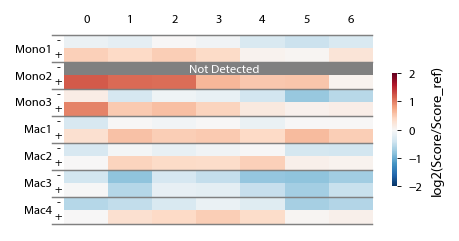

In [31]:
# plot heatmap
h = scores.shape[1]/150.+4
w = scores.shape[0]*0.5+0.8
fig,gs = rz.startfig(w,h,rows=1,return_first_ax=False)
  
# for saving heatmaps as separate excel sheets
figkey = 'momac_fgsea-leading-genes_score_HM'
fname = 'Aug20_BLZ_data/%s'%figkey
print(fname)

# save excel tables with data
# writer = pd.ExcelWriter('%s.xlsx'%fname)
    
a = fig.add_subplot(gs[0,0])
hmap = a.matshow(scores,vmin=-thelim,vmax=thelim,cmap=cmap,aspect='auto')
rz.showspines(a)

# xticks_fancy(a,scores.columns,scores.columns, fontsize=5)
# a.set_yticks(np.arange(heat.shape[0]))
# a.set_yticklabels(heat.index, fontsize=7)
a.set_xlabel('')
a.set_yticklabels('')
a.set_ylabel('')
label_group_hm(a, scores)
a.text(a.get_xlim()[1]/2.8, 2.2, 'Not Detected', fontsize=6, color='white')

cbar = fig.colorbar(hmap, shrink=0.6)
cbar.outline.set_visible(False)
cbar.set_label('log2(Score/Score_ref)',fontsize=7)
gs.tight_layout(fig)

cmap.set_bad(color='grey')
# save excel
# a bit slow...
# rz.color_dataframe_cells(heat,vmin=-thelim,vmax=thelim,cmap=cmap).to_excel(writer,i)
    
# writer.save()
plt.savefig('%s.pdf'%fname)

plt.show() 

In [68]:
fname = 'Working analysis stuff/GOids_LE-genes-in-path.txt'
with open(fname, 'w') as f:
    for p in ids_list:
        f.write(p)
        f.write('\t')
        f.write(', '.join(g for g in pg[p]))
        f.write('\n')

In [76]:
scores = pd.DataFrame(index=centroids_f.index)
id_d = {}

for p in ids_list:
    tmp = centroids_f.loc[:,pg[p]]
    scores = tmp.multiply(x, axis=0)
    id_d[p] = p
    fname = 'Working analysis stuff/genes_weighted_score_{}.txt'.format(p)
    scores.to_csv(fname, sep='\t', mode='w')

In [88]:
gp = {}

for p in ids_list:
    for g in pg[p]:
        if g in gp:
            gp[g].append(p)
        else:
            gp[g] = [p]

for g in gp:
    tmp = centroids_f.loc[:,g]
    tmp = tmp.multiply(x, axis=0)
    gp[g].append(tmp.values)

fname = 'Working analysis stuff/GOids_path-score-for-LE-genes.txt'
with open(fname, 'w') as f:
    f.write('gene\tpathways\tscores (Mo1-/+, Mo2-/+, Mo3-/+, Ma1-/+, Ma2-/+, Ma3-/+, Ma4-/+)\n')
    for g in gp:
        f.write(g)
        f.write('\t')
        f.write(', '.join(p for p in gp[g][:-1]))
        f.write('\t')
        f.write(', '.join(str(p) for p in gp[g][-1]))
        f.write('\n')

In [42]:
fname = 'Working analysis stuff/momac-allpathways_leading-genes_unweighted_score_HM.txt'
with open(fname, 'w') as f:
    for p in scores.columns:
        f.write(id_d[p])
        f.write('\n')